<a href="https://colab.research.google.com/github/GiulioCMSanto/HDSIdent/blob/master/notebooks/SISO%20Systems/Potential%20Intervals/siso_sliding_window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potential Intervals: Sliding Window Approach

Library: [HDSIdent: Historical Data Segmentation for System Identification](https://github.com/GiulioCMSanto/HDSIdent)

This notebook explores how to obtain potential intervals for system identification through a sliding window approach, considering Single-Input Single-Output systems.

**How to reference this work?**

[SANTO, G. C. M. Data Mining Techniques Applied to Historical Data of Industrial Processes 
as a Tool to Find Time Intervals Suitable for System Identification. Masters dissertation 
– Polytechnic School of the University of São Paulo, São Paulo, Brasil, 2020. 
DOI: 10.13140/RG.2.2.13295.46240](https://www.researchgate.net/publication/347511108_Data_Mining_Techniques_Applied_to_Historical_Data_of_Industrial_Processes_as_a_Tool_to_Find_Time_Intervals_Suitable_for_System_Identification?channel=doi&linkId=5fdf5293a6fdccdcb8e856c4&showFulltext=true)




**About the Method**

The method here presented was based in the following works:

```
SMITH, S. W. Digital Signal Processing. San Diego, California:
California Technical Publishing, 1999.

ARENGAS, D.; KROLL, A. A Search Method for Selecting Informative Data in Predominantly
Stationary Historical Records for Multivariable System Identification.
In: Proceedings of the 21st International Conference on System Theory,
Control and Computing (ICSTCC). Sinaia, Romenia: IEEE, 2017a. p. 100–105.

ARENGAS, D.; KROLL, A. Searching for informative intervals in predominantly stationary
data records to support system identification. In: Proceedings of the XXVI International
Conference on Information, Communication and Automation Technologies (ICAT). Sarajevo,
Bosnia-Herzegovina: IEEE, 2017b.
```

The implementation here presented, however, is also based on the following related works:

```
PERETZKI, D. et al. Data mining of historic data for process identification.
In: Proceedings of the 2011 AIChE Annual Meeting, p. 1027–1033, 2011.

BITTENCOURT, A. C. et al. An algorithm for finding process identification
intervals from normal operating data. Processes, v. 3, p. 357–383, 2015.

PATEL, A. Data Mining of Process Data in Mutlivariable Systems.
Degree project in electrical engineering — Royal Institute of Technology,
Stockholm, Sweden, 2016.

WANG, J. et al. Searching historical data segments for process identification
in feedback control loops. Computers and Chemical Engineering, v. 112, n. 6, p. 6–16, 2018.
```

**About the [Dataset](https://github.com/GiulioCMSanto/HDSIdent/tree/master/data/water_tank)**

The dataset here adopted was produced through simulation in the dissertation (SANTO, G. C. M., 2020). The dataset is created based on the work in (WANG et al., 2018). The transfer functions adopted in the simulation were directly extracted from (WANG et al., 2018 apud YU et al., 2011), as well as the simulation idea, where similar signals were produced.

**References**:

```
SANTO, G. C. M. Data Mining Techniques Applied to Historical Data of Industrial Processes 
as a Tool to Find Time Intervals Suitable for System Identification. Masters dissertation 
– Polytechnic School of the University of São Paulo, São Paulo, Brasil, 2020. 
DOI: 10.13140/RG.2.2.13295.46240

WANG, J. et al. Searching historical data segments for process identification
in feedback control loops. Computers and Chemical Engineering, v. 112, n. 6, p. 6–16, 2018.

YU, Z. et al. Performance assessment of pid control loops subject to setpoint
changes. Journal of Process Control, v. 21, n. 8, p. 1164–1171, 2011.
````

In [1]:
!git clone https://github.com/GiulioCMSanto/HDSIdent.git

Cloning into 'HDSIdent'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 808 (delta 40), reused 38 (delta 15), pack-reused 715
Receiving objects: 100% (808/808), 9.86 MiB | 26.22 MiB/s, done.
Resolving deltas: 100% (377/377), done.


In [ ]:
# Change into the directory for install
%cd HDSIdent/

/content/HDSIdent


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating HDSIdent.egg-info
writing HDSIdent.egg-info/PKG-INFO
writing dependency_links to HDSIdent.egg-info/dependency_links.txt
writing requirements to HDSIdent.egg-info/requires.txt
writing top-level names to HDSIdent.egg-info/top_level.txt
writing manifest file 'HDSIdent.egg-info/SOURCES.txt'
writing manifest file 'HDSIdent.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/HDSIdent
copying HDSIdent/__init__.py -> build/lib/HDSIdent
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/HDSIdent
copying build/lib/HDSIdent/__init__.py -> build/bdist.linux-x86_64/egg/HDSIdent
byte-compiling build/bdist.linux-x86_64/egg/HDSIdent/__init__.py to __init__.cpython-36.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying HDSIdent.egg-info/PKG-INFO -> build/bdist.linu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

plotly.io.renderers.default = 'colab'

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
from HDSIdent.data_treatment.data_preprocessing import Preprocessing
from HDSIdent.initial_intervals.sliding_window import SlidingWindow

## **1. Read Data**

In [ ]:
mv_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_mv.csv'
sp_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_sp.csv'
y_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_y.csv'

In [ ]:
mv = pd.read_csv(mv_url, error_bad_lines=False, header=None)
sp = pd.read_csv(sp_url, error_bad_lines=False, header=None)
y = pd.read_csv(y_url, error_bad_lines=False, header=None)

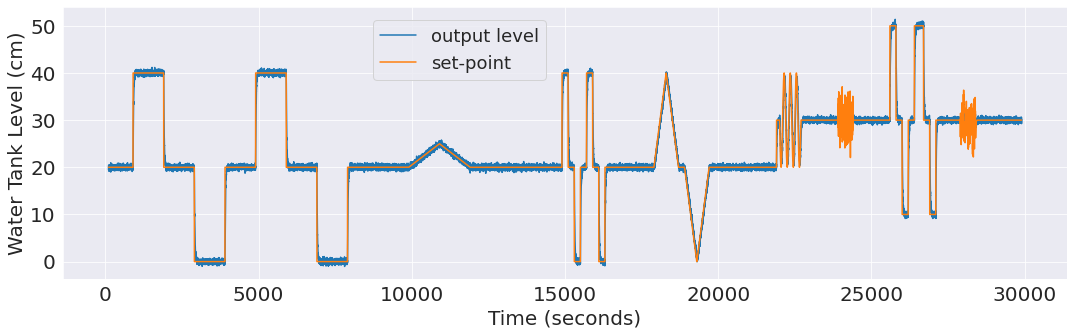

In [ ]:
plt.figure(figsize=(18,5));
plt.plot(y[100:],label="output level");
plt.plot(sp[100:],label="set-point");
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.ylabel("Water Tank Level (cm)", fontsize=20);
plt.xlabel("Time (seconds)", fontsize=20);
plt.legend(fontsize=18,bbox_to_anchor=(0.3,0.7));

## **2. Data Preprocessing**

In [ ]:
pp = Preprocessing(
        scaler='MinMaxScaler',
        feature_range=(-0.5,0.5),
        k=100);

In [ ]:
X_clean, Y_clean = pp.fit_transform(X=np.concatenate([mv,sp],axis=1),
                                    y=y)

In [ ]:
df = pd.DataFrame()
df['U'] = X_clean[:,0]
df['SP'] = X_clean[:,1]
df['Y'] = Y_clean

In [ ]:
df.head()

,U,SP,Y
0,0.003182,-0.1,-0.109338
1,-0.000913,-0.1,-0.106037
2,-0.009513,-0.1,-0.099186
3,-0.012116,-0.1,-0.097125
4,-0.008668,-0.1,-0.099873


## **3. Potential Intervals**

In [ ]:
sw = SlidingWindow(
            window_size=200, 
            H_v = [0.003,0.003], 
            min_input_coupling=1,
            min_output_coupling=1,
            num_previous_indexes=0,
            min_interval_length=None,
            n_jobs=-1, 
            verbose=0
        )

In [ ]:
start = time()
sw.fit(X=df[['SP']], y=df[['Y']])
end = time()

In [ ]:
print("Execution Time: {}".format(end-start))

Execution Time: 1.172795295715332


In [ ]:
indicating_sequences = sw.unified_indicating_sequence
indicating_sequences[np.argwhere(indicating_sequences==1)]=0.5
indicating_sequences[np.argwhere(indicating_sequences==0)]=-0.5

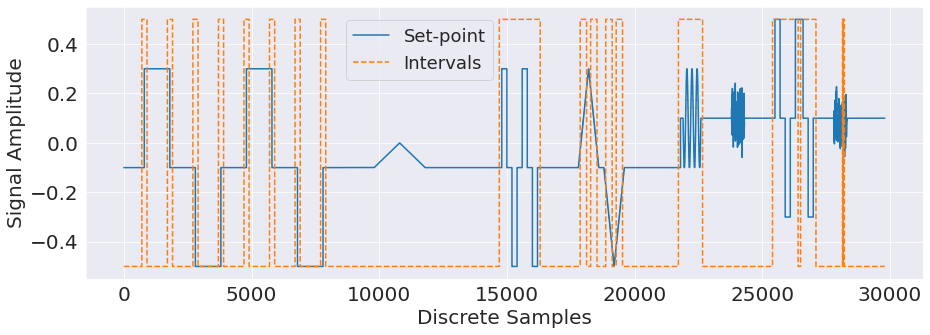

In [ ]:

plt.figure(figsize=(15,5));
plt.step(range(0,df[['SP']].shape[0]),df[['SP']], label='Set-point');
plt.step(range(0,df[['SP']].shape[0]),indicating_sequences,linestyle='--', label='Intervals');
plt.legend(fontsize=18,bbox_to_anchor=(0.3,0.7));
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.xlabel("Discrete Samples", fontsize=20);
plt.ylabel("Signal Amplitude", fontsize=20);

## **4. How the method works**

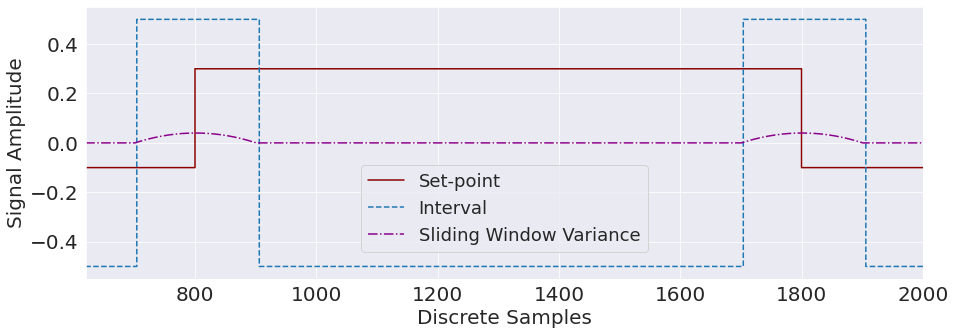

In [ ]:
plt.figure(figsize=(15,5));
plt.step(range(0,df[['SP']].shape[0]),df[['SP']],color='darkred',label='Set-point');
plt.step(range(0,df[['SP']].shape[0]),indicating_sequences,linestyle='--',label='Interval');
plt.plot(sw.var_arr['SP'],color='darkmagenta',linestyle='-.',label='Sliding Window Variance');
plt.xlim([620,2000]);
plt.legend(bbox_to_anchor=(0.5, 0.45),fontsize=18);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.xlabel("Discrete Samples", fontsize=20);
plt.ylabel("Signal Amplitude", fontsize=20);

## **5. Impact of the Window Size**

In [ ]:
window_size_arr = list(range(10,200))
num_intervals = []

for window_size in window_size_arr:
    
    sw = SlidingWindow(
                window_size=window_size, 
                H_v = [0.003,0.002], 
                min_input_coupling=1,
                min_output_coupling=1,
                num_previous_indexes=0,
                min_interval_length=None,
                n_jobs=-1, 
                verbose=0
            )

    intervals = sw.fit(X=df[['SP']], 
                       y=df[['Y']])

    num_intervals.append(len(intervals.keys()))

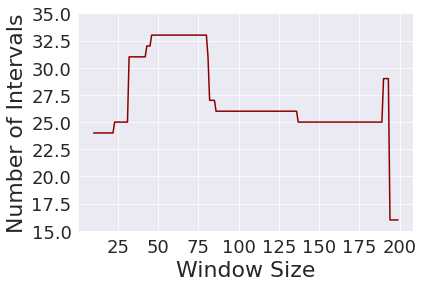

In [ ]:
plt.plot(window_size_arr,num_intervals, color='darkred');
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.ylim([15,35]);
plt.xlabel("Window Size", fontsize=22);
plt.ylabel("Number of Intervals", fontsize=22);

## **6. Impact of Window Size and Variance Threshold**

In [ ]:
window_arr = np.arange(10,250,20)
thr_arr = [0.001, 0.002, 0.004, 0.008, 0.016, 0.04]

window_arr, thr_arr = np.meshgrid(window_arr, thr_arr)
num_intervals_mtx = np.zeros((window_arr.shape[0],window_arr.shape[1]))

counter = 0
for idx_1 in range(window_arr.shape[0]):
    for idx_2 in range(window_arr.shape[1]):
        
        counter+=1
        
        if counter%20==0:
            print("Iteration {}/{}".format(counter,window_arr.shape[0]*window_arr.shape[1]))
    
        window = window_arr[idx_1,idx_2]
        thr = thr_arr[idx_1,idx_2]
        

        sw = SlidingWindow(
                    window_size=window, 
                    H_v = [thr,thr], 
                    min_input_coupling=1,
                    min_output_coupling=1,
                    num_previous_indexes=0,
                    min_interval_length=None,
                    n_jobs=-1, 
                    verbose=0
                )
        
        intervals = sw.fit(X=df[['SP']],y=df[['Y']]);

        num_intervals_mtx[idx_1,idx_2] = len(intervals.keys())

Iteration 20/72
Iteration 40/72
Iteration 60/72


In [ ]:
window_arr = np.arange(10,250,20)
thr_arr = [0.001, 0.002, 0.004, 0.008, 0.016, 0.04]

fig = go.Figure(data =
    go.Contour(
        z=num_intervals_mtx,
        x=window_arr, # horizontal axis
        y=thr_arr, # vertical axis,
        zmin=0,
        zmax=40,
        colorscale='bugn',
                contours=dict(
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 26,
                color = 'black',
            )
    )))

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    title={'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_title=r"$\Large \text{Window Size } w_{s}$",
    yaxis_title=r"$\Large \text{Variance Threshold  } l_{S}$",
    font=dict(
        family="Times New Roman",
        size=22,
        color="black"
    ),
)

fig.show()